# Minimal Working Example: Use a trained model for cyclist simulation.

This is a minimal example demonstrating how to 
- load a pole model for stochastic rider behavior
- create a bicycle model
- simulate a heading step response with the model

## Loading an existing pole model

The parameters of the trained behavioral models are deposited as `.yaml` textfiles in the [data repository](https://doi.org/10.4121/f881dd80-b9f5-4322-9fd5-192034c9717f). Create a `rcid.pole_modelling.PoleModel` object from these paramters to draw random pole samples: 

*Adjust path if the kernel did not start in the repo root.*

In [25]:
from rcid.pole_modelling import PoleModel

speed = 4.0     #speed in m/s 
n_samples = 3   #number of samples to draw

filepath_modelparams = "{REPO_DIR}\\assets\\pole_models\\BR0_ImRe5GivenV_pole-model-params.yaml"
filepath_modelparams = "U:\\CyclistInteractionAndControl\\bicycle-control-experiment\\shared\\code\\assets\\pole_models\\BR0_ImRe5GivenV_pole-model-params.yaml"

pm = PoleModel.import_from_yaml(filepath_modelparams, random_state=42)
poles, _ = pm.sample_poles(n_samples=n_samples, X_given=speed)

poles

array([[ -5.40417136+0.j        ,  -1.43881486+1.49694695j,
         -1.43881486-1.49694695j,  -1.08974675+3.84862613j,
         -1.08974675-3.84862613j],
       [-23.26287807+0.j        ,  -0.39797468+1.52732783j,
         -0.39797468-1.52732783j,  -0.57932804+6.80631802j,
         -0.57932804-6.80631802j],
       [-16.97381995+0.j        ,  -0.95451525+2.9955135j ,
         -0.95451525-2.9955135j ,  -1.48811612+6.35815481j,
         -1.48811612-6.35815481j]])

## Simulate a step response with a bicycle model

The dynamic models used in this repository are implemented in the package `cyclistsocialforce`. This package provides `cyclistsocialforce.vehicle.BalancingRiderBicycle()` and `cyclistsocialforce.vehicle.PlanarPointBicycle()`, implementing the dynamics of our two models and including speed control. For the present publication, the forward speed was fixed to the known measured speed (i.e., no speed control). For that, three derived classes are available in `rcid.simulation`:

- `FixedSpeedBalancingRiderBicycle(BalancingRiderBicycle)`: Balancing rider dynamics with fixed, prescribed speed trajectory.
- `FixedSpeedPlanarPointBicycle(PlanarPointBicycle)`: Planar point dynamics with fixed, prescribed speed trajectory.
- `FixedResponseTimePlanarPointBicycle(FixedSpeedPlanarPointBicycle)`: Planar point dynamics with fixed, prescribed speed trajectory and a fixed input delay compensating for the difference between tau_cs and tau_ec (see the paper for more details).


> **⚠️ Warning**
>
> The original `cyclistsocialforce.vehicle.BalancingRiderBicycle` has a speed controller, but the rider behavior models proposed in the present study were not calibrated or tested together with this. `BalancingRiderBicycle` does not ensure (yet) that speed-dependend poles are updated if the speed changes. 


Create a bicycle and run a rudimentary simulation for the three different pole samples generated above in the following way:

\\tudelft.net\staff-umbrella\PhDConnectedVRU\Projects\cyclistsocialforce\cyclistsocialforce-v1.x.x\src\cyclistsocialforce\vehicle.py:787: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[-1].legend()


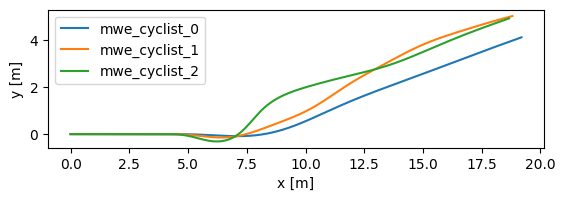

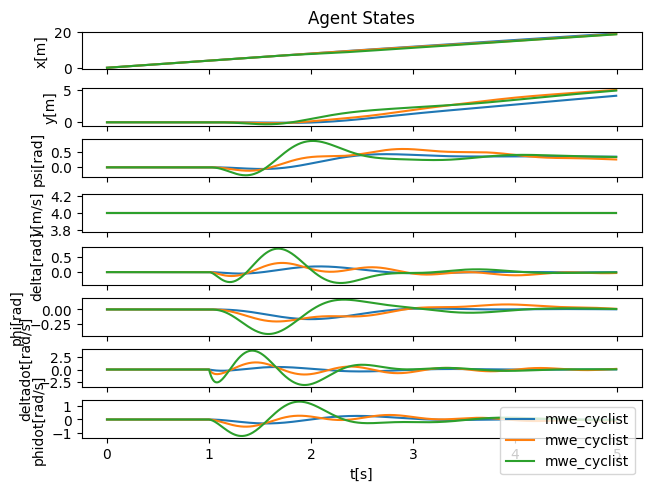

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from rcid.simulation import FixedSpeedBalancingRiderBicycle, Balanceassistv1BalancingRiderParameters

fig, ax = plt.subplots(1,1)
ax.set_aspect("equal")
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")

axes_states = None

## create a bicycle object
s0 = [0, 0, 0, speed, 0, 0, 0, 0]   # the initial state [x, y, yaw, speed, steer, roll, steerrate, rollrate]

for j in range(poles.shape[0]):
      params = Balanceassistv1BalancingRiderParameters(     # This paramters class represents a bicycle with the physical parameters of the bike used in the experiment.
            v_desired_default = speed,    # set the desired speed. The FixedSpeed models will exactly keep that speed
            poles=poles[j,:],             # set the behavioral parameter to a pole sample
      )
      bike = FixedSpeedBalancingRiderBicycle(s0, id='mwe_cyclist', params=params)

      ## simulate a 20 deg stepresponse
      N = 500
      psi_c = np.zeros(N)
      psi_c[int(N/5):] = np.deg2rad(20)

      Fx = speed * np.cos(psi_c)
      Fy = speed * np.sin(psi_c)

      for i in range(N):
            bike.step(Fx[i], Fy[i])

      ## plot 
      ax.plot(bike.traj[0,:N], bike.traj[1,:N], label=f"{bike.id}_{j}")

      axes_states = bike.plot_states(axes=axes_states, t_end=N*bike.params.t_s, plot_over_time=True)

ax.legend()

## Complex Scenarios and Animation

To create more complex scenarios and show an animation of the simulation, `cyclistsocialforce.scenario` provides a `Scenario` base class. This also allows to use the models proposed in this paper together with the cyclistsocialforce framework for multi-agent interaction. For more guidance, consult the following examples:
- `cyclistsocialforce` demo for creating custom scenarios: https://github.com/chris-konrad/cyclistsocialforce/blob/main/demo/demoCSFstandalone.py
- `rcid.simulation.FixedInputZigZagTest`: A scenario recreating the real-world experiment conducted as part of the present study
- `rcid.simulation.FixedSpeedStaticObstacleAvoidance`: The obstacle avoidance scenario used as test case in the present study.
